# **CLASSIFYING FAKE NEWS USING LSTM**



In [1]:
#importing libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#reading data
ds = pd.read_csv('../2.data_preprocessing/no_pre.csv')

In [3]:
#displaying data
ds.head()

,News,Title,Label
0,The Internet is buzzing today after white supr...,5 Million Uncounted Sanders Ballots Found On C...,Fake
1,TRUMP TOWER — With his poll numbers among blac...,African Billionaire Will Give $1 Million To An...,Fake
2,Donald Trump is looking to assemble a strong t...,BREAKING Another Clinton Associate Set To Test...,Fake
3,"“SHE’S SEXY, SMART, SOPHISTICATED, AND SHE’S I...",Breaking Fraudulent Clinton Votes Discovered B...,Fake
4,"PHOENIX A.Z. (AP) — For months now, rumors hav...",BREAKING Official Set to Testify Against Hilla...,Fake


In [4]:
#checking null values
ds.isnull().sum()

News     0
Title    0
Label    5
dtype: int64

**DROPPING NULL VALUES**

In [5]:
#dropping null values
ds = ds.dropna()
ds.isnull().sum()

News     0
Title    0
Label    0
dtype: int64

In [6]:
#after dropping null values,indexes will be unordered therfore resetting indexes
ds.reset_index(inplace = True,drop = True)
ds.head()

,News,Title,Label
0,The Internet is buzzing today after white supr...,5 Million Uncounted Sanders Ballots Found On C...,Fake
1,TRUMP TOWER — With his poll numbers among blac...,African Billionaire Will Give $1 Million To An...,Fake
2,Donald Trump is looking to assemble a strong t...,BREAKING Another Clinton Associate Set To Test...,Fake
3,"“SHE’S SEXY, SMART, SOPHISTICATED, AND SHE’S I...",Breaking Fraudulent Clinton Votes Discovered B...,Fake
4,"PHOENIX A.Z. (AP) — For months now, rumors hav...",BREAKING Official Set to Testify Against Hilla...,Fake


In [7]:
ds.columns

Index(['News', 'Title', 'Label'], dtype='object')

In [8]:
#defining dependent and independent vectors
#taking only news for prediction
x = ds['News']
y = ds['Label']

In [9]:
x.head()

0    The Internet is buzzing today after white supr...
1    TRUMP TOWER — With his poll numbers among blac...
2    Donald Trump is looking to assemble a strong t...
3    “SHE’S SEXY, SMART, SOPHISTICATED, AND SHE’S I...
4    PHOENIX A.Z. (AP) — For months now, rumors hav...
Name: News, dtype: object

<AxesSubplot:xlabel='Label', ylabel='count'>

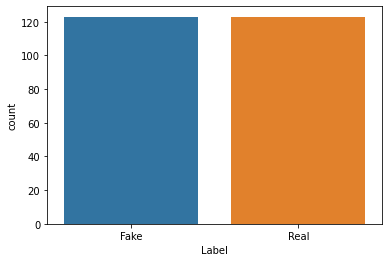

In [10]:
#checking number of real and fake news
sns.countplot(x = 'Label',data = ds)

**ALMOST 10000 ARE RELIABLE(0) AND 8000 ARE UNRELIABLE(1)**

In [11]:
#Text Cleaning and preprocessing
cleaned = []
for i in range(0,len(ds)):
    
    #removing words any other than (a-z) and (A-Z)
    text = re.sub('[^a-zA-Z]',' ', x[i])
    
    #converting all words into lower case
    text = text.lower()
    
    #tokenizing 
    text = text.split()
    
    #stemming and removing stopwords
    ps = PorterStemmer()
    text = [ps.stem(words) for words in text if words not in stopwords.words('english')]
    text = ' '.join(text)
    cleaned.append(text)

In [12]:
#cleaned text
cleaned[:5]

['internet buzz today white supremacist presidenti candid donald trump caught hotel staff snort cocain maria gonzalez employe folk inn suit hotel phoenix brought room servic room wit walk saw nake prostitut mayb hundr dollar bill mountain white powder tabl thought dog floor sleep hair piec bald sweat like crazi ask put food ask wanna take hit told take money call free loader told get f ck room go back countri reach trump campaign releas statement say disrespect woman god damn liar drug busi get elect hotel employe u citizen keep take real american peopl job stop watch maria gonzalez cell phone video happen contact sever media outlet sell footag expect video hit internet day stay tune',
 'trump tower poll number among black voter hover around presumpt gop nomine donald trump reportedli tap actress fox news contributor stacey dash negro outreach program ambassador connect group said trump terrif see oscar terrif minor outreach director brought board lucki controversi one good one dash re

In [13]:
#taking dictionary size 5000
vocab_size = 5000

#one hot encoding
one_hot_dir = [one_hot(words,vocab_size) for words in cleaned]

#length of all rows should be equal therefore applying padding
#this will adjust size by adding 0 at staring of the shorter rows
embedded_layer = pad_sequences(one_hot_dir,padding = 'pre')
embedded_layer

array([[   0,    0,    0, ..., 1920, 2259,   67],
       [   0,    0,    0, ..., 2471, 2679, 3293],
       [   0,    0,    0, ..., 3982, 1052, 4260],
       ...,
       [   0,    0,    0, ..., 4544, 1674, 4616],
       [   0,    0,    0, ...,  946, 2342, 3516],
       [   0,    0,    0, ..., 1736, 4297, 3520]])

**LENGTH OF ALL ROWS IS EQUAL NOW**

In [14]:
#converting into numpy arrays.
x = np.array(embedded_layer)
y = np.array(y)

In [15]:
#converting target variable to numerical representation
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(y.astype(str))

In [16]:
#splitting the Dataset into Train and Test set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [17]:
#callback function, if a threshold is met during training, this function will stop training
import tensorflow as tf
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [18]:
#creating model using LSTM
model = Sequential()

#taking number features as 50
model.add(Embedding(vocab_size,50,input_length = len(embedded_layer[0])))
model.add(Dropout(0.5))

#adding LSTM layers with 100 neurons
model.add(LSTM(100))
model.add(Dropout(0.5))

#adding output layer 
model.add(Dense(1,activation="sigmoid"))

#compiling the model
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [19]:
#summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4268, 50)          250000    
_________________________________________________________________
dropout (Dropout)            (None, 4268, 50)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 310,501
Trainable params: 310,501
Non-trainable params: 0
_________________________________________________________________


In [20]:
my_callback = MyThresholdCallback(threshold=0.8)
#training the model
history = model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs = 8, batch_size = 16, callbacks=[my_callback])

Epoch 1/8
13/13 [==============================] - 57s 4s/step - loss: 0.6937 - accuracy: 0.4718 - val_loss: 0.6949 - val_accuracy: 0.4600
Epoch 2/8
13/13 [==============================] - 54s 4s/step - loss: 0.6871 - accuracy: 0.5650 - val_loss: 0.6953 - val_accuracy: 0.4600
Epoch 3/8
13/13 [==============================] - 53s 4s/step - loss: 0.6998 - accuracy: 0.7349 - val_loss: 0.6780 - val_accuracy: 0.5800
Epoch 4/8
13/13 [==============================] - 54s 4s/step - loss: 0.6449 - accuracy: 0.7337 - val_loss: 0.6781 - val_accuracy: 0.5800
Epoch 5/8
13/13 [==============================] - 55s 4s/step - loss: 0.6354 - accuracy: 0.7649 - val_loss: 0.6682 - val_accuracy: 0.6000
Epoch 6/8
13/13 [==============================] - 52s 4s/step - loss: 0.5590 - accuracy: 0.8556 - val_loss: 0.5929 - val_accuracy: 0.7800
Epoch 7/8
13/13 [==============================] - 52s 4s/step - loss: 0.3900 - accuracy: 0.9939 - val_loss: 0.4785 - val_accuracy: 0.8200


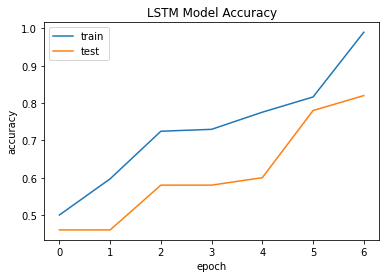

In [22]:
#plotting training and validation accuracy
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

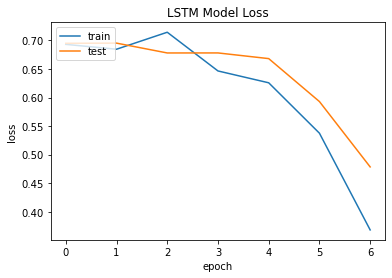

In [23]:
#plotting training and validation loss
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#predicting and getting accuracy
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

In [79]:
#getting confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[22,  7],
       [ 5, 16]], dtype=int64)